In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from urllib.request import urlopen
import requests
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from scipy import stats
from sklearn.ensemble import RandomForestClassifier 

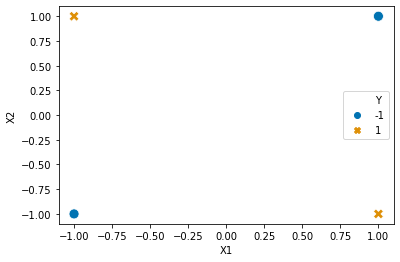

In [102]:
import seaborn as sns
data = [[-1, -1, -1], [-1, 1, 1], 
        [1, -1, 1],[1, 1, -1]
       ]
data = pd.DataFrame(data,columns=['X1','X2','Y'])
data

sns.scatterplot(x="X1", y="X2", hue="Y", style='Y',
              data=data, palette='colorblind', s=100)

In [103]:
import sklearn.preprocessing
poly = sklearn.preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(data[['X1','X2']])
coefs = np.array([1, np.sqrt(2), np.sqrt(2), 1, np.sqrt(2), 1])
X = pd.DataFrame( X * coefs )

In [104]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X, data.Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [105]:
# dual_coef_: Dual coefficients of the support vector 
# in the decision function (see Mathematical formulation), 
# multiplied by their targets.
# support_: indices of support vectors
print("Alpha vector:")
clf.dual_coef_ / data.Y.values[clf.support_]

Alpha vector:


array([[0.125, 0.125, 0.125, 0.125]])

### R Lab

In [106]:
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))
X = data.iloc[:, 1:16]
Y = data['DX_bl']

In [120]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='linear',C=10)

ncv = 10

error = 1 - cross_val_score(clf, X, Y, cv=ncv, scoring='accuracy')
print(np.mean(error))

error = 1 - cross_val_score(clf, X[['AGE', 'PTEDUCAT', 'FDG', 'AV45',
                                 'HippoNV', 'rs3865444','PTEDUCAT']], 
                         Y, cv=ncv, scoring='accuracy')
print(np.mean(error))

error = 1 - cross_val_score(clf, X[['AGE','PTEDUCAT']], Y, cv=ncv, scoring='accuracy')
print(np.mean(error))

error = 1 - cross_val_score(clf, X[['FDG', 'AV45','HippoNV']], 
                         Y, cv=ncv, scoring='accuracy')
print(np.mean(error))



0.17021116138763198
0.1547134238310709
0.4332202111613876
0.15275263951734538


In [126]:

x_train, x_test, y_train, y_test = train_test_split(X[['FDG', 'AV45','HippoNV']], Y, test_size=0.5)
clf = svm.SVC(kernel='linear',C=10,probability=True)
svm_linear = clf.fit(x_train, y_train)
ytest_score = svm_linear.predict_proba(x_test)[:,1]
ytest_pred = [ 0 if x < 0.5 else 1 for x in ytest_score]

from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, ytest_pred))


Confusion matrix:
[[122  29]
 [ 22  86]]


Text(0.5, 1.0, 'ROC Curve')

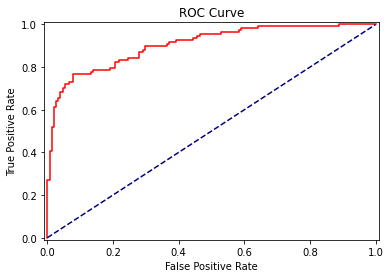

In [127]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, ytest_score)
plt.plot(fpr, tpr, color = 'red', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # random prediction
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### SVM parameter tuning

In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
                        X[['FDG', 'AV45','HippoNV']], 
                        Y, test_size=0.5)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        svm.SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.832 (+/-0.094) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
0.832 (+/-0.094) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.850 (+/-0.066) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
0.850 (+/-0.066) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
0.871 (+/-0.105) for {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
0.871 (+/-0.105) for {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
0.863 (+/-0.077) for {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}
0.863 (+/-0.077) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'linear'}
0.832 (+/-0.094) for {'C': 1, 'kernel': 'linear'}
0.850 (+/-0.066) for {'C': 10, 'kernel': 'linear'}
0.871 (+/-0.105) for {'C': 100, 'kernel': 'linear'}
0.863 (+/-0.077) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development se

### Comparison between decision tree, random forests and boosted trees

In [134]:
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))
X = data.iloc[:, 1:16]
Y = data['DX_bl']

In [148]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

error_df = pd.DataFrame()

for training_perc in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    for isampling in range(50):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                    test_size=training_perc)
        forest = RandomForestClassifier()
        forest.fit(x_train, y_train)
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(y_test)
        this_err = pd.DataFrame({'training_perc':[training_perc],
                                 'type':['randomforest'],
                                 'error':[this_error] })
        error_df = error_df.append(this_err)

        tree = DecisionTreeClassifier()
        tree.fit(x_train, y_train)
        pred_tree = tree.predict(x_test)
        this_error = sum(pred_tree != y_test)/len(y_test)
        this_err = pd.DataFrame({'training_perc':[training_perc],
                                 'type':['tree'],
                                 'error':[this_error] })
        error_df = error_df.append(this_err)

        boosting = GradientBoostingClassifier()
        boosting.fit(x_train, y_train)
        pred_boosting = boosting.predict(x_test)
        this_error = sum(pred_boosting != y_test)/len(y_test)
        this_err = pd.DataFrame({'training_perc':[training_perc],
                                 'type':['boosting'],
                                 'error':[this_error] })
        error_df = error_df.append(this_err)
    
error_df    


,training_perc,type,error
0,0.1,randomforest,0.096154
0,0.1,tree,0.173077
0,0.1,boosting,0.115385
0,0.1,randomforest,0.230769
0,0.1,tree,0.250000
...,...,...,...
0,0.7,tree,0.196133
0,0.7,boosting,0.160221
0,0.7,randomforest,0.154696
0,0.7,tree,0.143646


Text(0.5, 1.0, 'Error vs. number of trees')

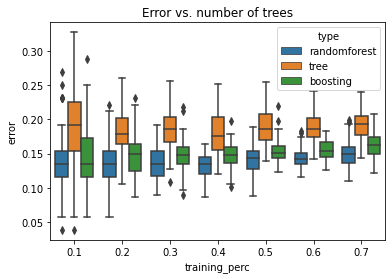

In [149]:
ax = sns.boxplot(x="training_perc", y="error", hue='type',data=error_df)
ax.set_title("Error vs. number of trees")

In [150]:
error_df = pd.DataFrame()

for num_trees in [10, 20, 50, 100, 200]:
    for isampling in range(50):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                    test_size=training_perc)
        forest = RandomForestClassifier(n_estimators=num_trees)
        forest.fit(x_train, y_train)
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(y_test)
        this_err = pd.DataFrame({'num_trees':[num_trees],
                                 'type':['randomforest'],
                                 'error':[this_error] })
        error_df = error_df.append(this_err)


        boosting = GradientBoostingClassifier(n_estimators=num_trees)
        boosting.fit(x_train, y_train)
        pred_boosting = boosting.predict(x_test)
        this_error = sum(pred_boosting != y_test)/len(y_test)
        this_err = pd.DataFrame({'num_trees':[num_trees],
                                 'type':['boosting'],
                                 'error':[this_error] })
        error_df = error_df.append(this_err)
    
error_df    

,num_trees,type,error
0,10,randomforest,0.179558
0,10,boosting,0.176796
0,10,randomforest,0.207182
0,10,boosting,0.165746
0,10,randomforest,0.154696
...,...,...,...
0,200,boosting,0.196133
0,200,randomforest,0.149171
0,200,boosting,0.165746
0,200,randomforest,0.138122


Text(0.5, 1.0, 'Error vs. number of trees')

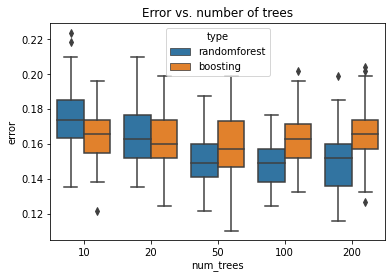

In [151]:
ax = sns.boxplot(x="num_trees", y="error", hue='type',data=error_df)
ax.set_title("Error vs. number of trees")

In [164]:

error_df = pd.DataFrame()

for complexity_cost in [0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]:
    for isampling in range(50):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                    test_size=0.5)

        tree = DecisionTreeClassifier(ccp_alpha=complexity_cost)
        tree.fit(x_train, y_train)
        pred_tree = tree.predict(x_test)
        this_error = sum(pred_tree != y_test)/len(y_test)
        this_err = pd.DataFrame({'complexity_cost':[complexity_cost],
                                 'type':['tree'],
                                 'error':[this_error] })
        error_df = error_df.append(this_err)
    

Text(0.5, 1.0, 'Error vs. complexity_cost')

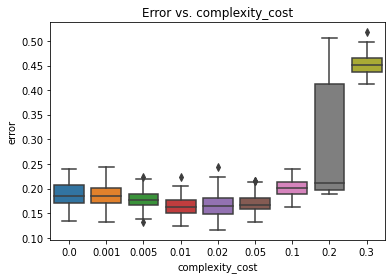

In [165]:
ax = sns.boxplot(x="complexity_cost", y="error", data=error_df)
ax.set_title("Error vs. complexity_cost")

In [166]:
### SVM Decision Boundary

In [190]:
# Generate data
data = pd.DataFrame( np.random.uniform(0, 1, size=[200, 2]),
                    columns=['X1','X2'])
data['X12'] = 0.5 * (data.X1 - data.X2)
data['Y'] = 1
data.loc[data.X12>0,'Y'] = 0

# plt.scatter(data.X1, data.X2, s=1, marker='o', c = data.Y)

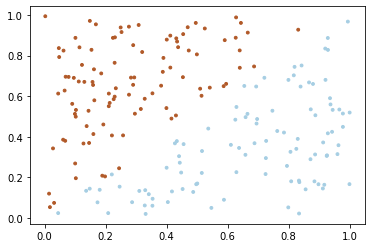

In [197]:
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(data[['X1','X2']], data.Y)
plt.scatter(data.X1, data.X2, c=data.Y, s=8, cmap=plt.cm.Paired)

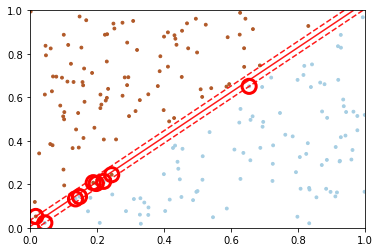

In [196]:
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

plt.scatter(data.X1, data.X2, c=data.Y, s=8, cmap=plt.cm.Paired)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='r', levels=[-1, 0, 1], alpha=0.9,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=200,
           linewidth=3, facecolors='none', edgecolors='r')
plt.show()